In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
folder_path = "D:\\violence"
files = os.listdir(folder_path)
mp4_files = [f for f in files if f.endswith(".mp4")]
mp4_file_paths = [os.path.join(folder_path, f) for f in mp4_files]

In [9]:
folder_path_nv = "D:\\non voilence"
files_nv = os.listdir(folder_path_nv)
mp4_files_nv = [f for f in files_nv if f.endswith(".mp4")]
mp4_file_paths_nv = [os.path.join(folder_path_nv, f) for f in mp4_files_nv]

In [3]:
def vid_to_numpy(video_path,array_rgb,array_flow):
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Calculate dense optical flow for each frame in the video
    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        # Calculate the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

     # Visualize the dense optical flow
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

        # Display the frame with dense optical flow
        #cv2.imshow("Optical Flow", bgr)
        #cv2.imshow('RGB', frame2)
        array_rgb.append(np.array(frame2))
        array_flow.append(np.array(bgr))
        # Break the loop if the user presses the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Set the previous frame to the current frame
        prvs = next
    cap.release()
    cv2.destroyAllWindows()

In [11]:
def max_mag(video_path):
    cap = cv2.VideoCapture(video_path)
    frames=[]
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Calculate dense optical flow for each frame in the video
    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        # Calculate the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

     # Visualize the dense optical flow
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

        # Display the frame with dense optical flow
        cv2.imshow("Optical Flow", bgr)
        cv2.imshow('RGB', frame2)
        frames.append(bgr)

        # Break the loop if the user presses the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Set the previous frame to the current frame
        prvs = next
    cap.release()
    cv2.destroyAllWindows()
    max_value=[]
    for i in range(0,len(frames)):
        max_value.append(np.linalg.norm(frames[i]))
    
    x=max(max_value)
    return x

In [12]:
magnitude_voilence=[]
for i in tqdm(range(0,len(mp4_file_paths))): 
    x=max_mag(mp4_file_paths[i])
    magnitude_voilence.append(x)

  0%|          | 0/1320 [00:00<?, ?it/s]

In [13]:
magnitude_non=[]
for i in tqdm(range(0,len(mp4_file_paths_nv))): 
    x=max_mag(mp4_file_paths_nv[i])
    magnitude_non.append(x)

  0%|          | 0/3043 [00:00<?, ?it/s]

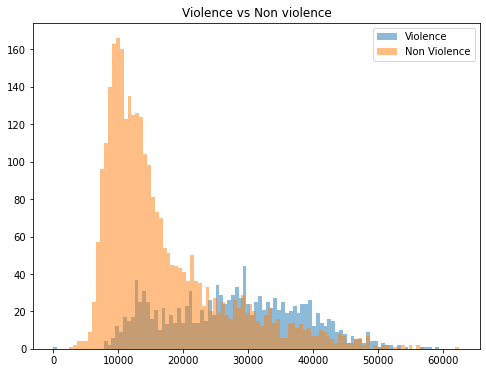

In [14]:
plt.figure(figsize=(8,6))
plt.hist(magnitude_voilence, bins=100, alpha=0.5, label="Violence")
plt.hist(magnitude_non, bins=100, alpha=0.5, label="Non Violence")
plt.title("Violence vs Non violence")
plt.legend(loc='upper right')
plt.show()

In [15]:
magnitude_non_np=np.array(magnitude_non)
magnitude_voilence_np=np.array(magnitude_voilence)
#save the magnitude of non violence and violence videos
np.save("magnitude_non_2",magnitude_non_np)
np.save("magnitude_voilence_2",magnitude_voilence_np)

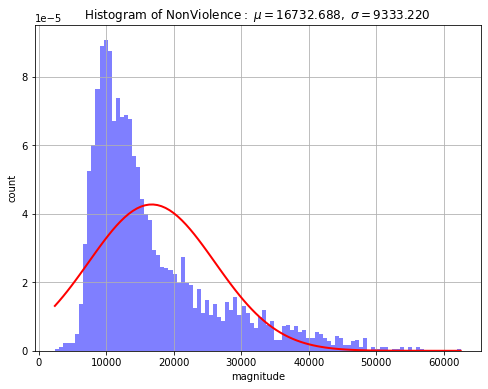

In [16]:
#plot the magnitude_non and magnitude_voilence in a gaussian distribution
from scipy.optimize import curve_fit
from scipy.stats import norm

(mu, sigma)=norm.fit(magnitude_non_np)
x = np.linspace(magnitude_non_np.min(), magnitude_non_np.max(), 100)
hist, bins = np.histogram(magnitude_non_np, bins=100, density=True)
pdf = norm.pdf(x, mu, sigma)
pdf_scaled = pdf * np.sum(np.diff(np.histogram(magnitude_non_np, bins=100, density=True)[1]) * np.histogram(magnitude_non_np, bins=100, density=True)[0])
#plot
plt.figure(figsize=(8,6))
plt.plot(x, pdf_scaled, 'r-', linewidth=2)
plt.hist(magnitude_non_np, bins=100, density=True, alpha=0.5, label="Non Violence",facecolor='b')
plt.xlabel('magnitude')
plt.ylabel('count')
plt.title(r'$\mathrm{Histogram\ of\ Non Violence:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

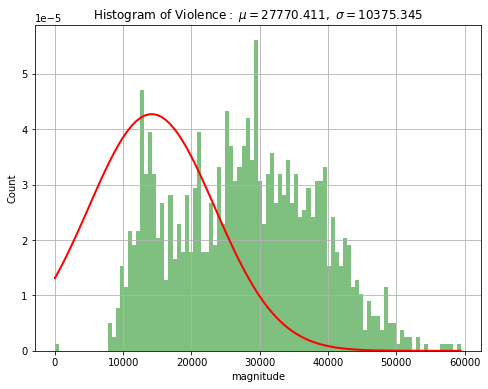

In [17]:
(mu, sigma)=norm.fit(magnitude_voilence_np)
z = np.linspace(magnitude_voilence_np.min(), magnitude_voilence_np.max(), 100)
hist, bins = np.histogram(magnitude_voilence_np, bins=100, density=True)
pdf = norm.pdf(x, mu, sigma)
pdf_scaled_1 = pdf * np.sum(np.diff(np.histogram(magnitude_voilence_np, bins=100, density=True)[1]) * np.histogram(magnitude_voilence_np, bins=100, density=True)[0])
#plot
plt.figure(figsize=(8,6))
plt.plot(z, pdf_scaled, 'r-', linewidth=2)
plt.hist(magnitude_voilence_np, bins=100, density=True, alpha=0.5, label="Violence",facecolor='g')
plt.xlabel('magnitude')
plt.ylabel('Count')
plt.title(r'$\mathrm{Histogram\ of\ Violence:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)



In [18]:
#load the magnitude of non violence and violence npy files
magnitude_non=np.load("magnitude_non_2.npy")
magnitude_voilence=np.load("magnitude_voilence_2.npy")

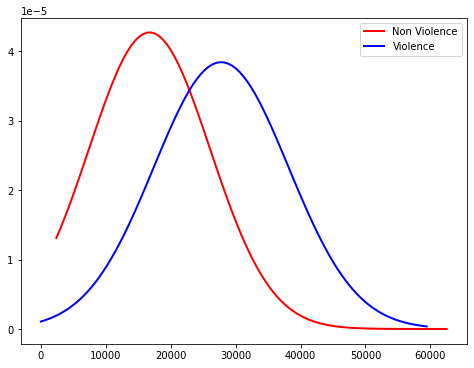

In [19]:
from scipy.stats import norm
(mu1, sigma1)=norm.fit(magnitude_non)
(mu2, sigma2)=norm.fit(magnitude_voilence)
hist1, bins1 = np.histogram(magnitude_non, bins=100, density=True)
hist2, bins2 = np.histogram(magnitude_voilence, bins=100, density=True)
x1 = np.linspace(magnitude_non.min(), magnitude_non.max(), 100)
x2 = np.linspace(magnitude_voilence.min(), magnitude_voilence.max(), 100)
pdf1 = norm.pdf(x1, mu1, sigma1)
pdf2 = norm.pdf(x2, mu2, sigma2)
pdf_scaled_1 = pdf1 * np.sum(np.diff(np.histogram(magnitude_non, bins=100, density=True)[1]) * np.histogram(magnitude_non, bins=100, density=True)[0])
pdf_scaled_2 = pdf2 * np.sum(np.diff(np.histogram(magnitude_voilence, bins=100, density=True)[1]) * np.histogram(magnitude_voilence, bins=100, density=True)[0])
#plot
plt.figure(figsize=(8,6))
plt.plot(x1, pdf_scaled_1, 'r-', linewidth=2, label="Non Violence")
plt.plot(x2, pdf_scaled_2, 'b-', linewidth=2, label="Violence")
plt.legend(loc='upper right')

plt.show()

In [4]:

violence_array_rgb=[]
violence_array_flow=[]
for i in tqdm(range(0,len(mp4_file_paths))):
    vid_to_numpy(mp4_file_paths[i],violence_array_rgb,violence_array_flow)
violence_array_rgb_np=np.array(violence_array_rgb)
violence_array_flow_np=np.array(violence_array_flow)
np.save("violence_array_rgb_np.npy",violence_array_rgb_np)
np.save("violence_array_flow_np.npy",violence_array_flow_np)


  0%|          | 0/1320 [00:00<?, ?it/s]

In [ ]:
non_violence_array_rgb=[]
non_violence_array_flow=[]
for i in tqdm(range(0,len(mp4_file_paths_nv))):
    vid_to_numpy(mp4_file_paths_nv[i],non_violence_array_rgb,non_violence_array_flow)
non_violence_array_rgb_np=np.array(non_violence_array_rgb)
non_violence_array_flow_np=np.array(non_violence_array_flow)
np.save("non_violence_array_rgb_np.npy",non_violence_array_rgb_np)
np.save("non_violence_array_flow_np.npy",non_violence_array_flow_np)

In [ ]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = violence_array_rgb[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

In [ ]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = violence_array_flow[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

In [ ]:
figure,axis = plt.subplots(5,5,figsize=(12,12))
for i,ax in enumerate(axis.flat):
    
    Img_Pick = non_violence_array_rgb[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

In [ ]:
figure,axis = plt.subplots(5,5,figsize=(12,12))
for i,ax in enumerate(axis.flat):
        
        Img_Pick = non_violence_array_flow[i]
        
        ax.set_xlabel(Img_Pick.shape)
        ax.imshow(Img_Pick)
    
plt.tight_layout()
plt.show()